# 🔁 Smart Hybrid Gas Blending Simulator
A Colab-ready notebook to optimize helium and substitute gas mixes based on cost, thermal performance, and inertness.

In [1]:

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

gases = {
    "He": {"thermal_cond": 0.1513, "cost": 30.0, "inert_score": 10},
    "Ne": {"thermal_cond": 0.0491, "cost": 20.0, "inert_score": 10},
    "Ar": {"thermal_cond": 0.0177, "cost": 2.5, "inert_score": 10},
    "H2": {"thermal_cond": 0.1805, "cost": 1.5, "inert_score": 3},
}
gas_names = list(gases.keys())
thermal_cond = np.array([gases[g]["thermal_cond"] for g in gas_names])
cost = np.array([gases[g]["cost"] for g in gas_names])
inert_score = np.array([gases[g]["inert_score"] for g in gas_names])

def optimize_mix(target_perf, lambda_cost, lambda_inert):
    def objective(x):
        x = np.clip(x, 0, 1)
        x /= np.sum(x)
        perf = np.dot(x, thermal_cond)
        blend_cost = np.dot(x, cost)
        inert_penalty = 1 - np.dot(x, inert_score) / 10.0
        return (perf - target_perf)**2 + lambda_cost * blend_cost + lambda_inert * inert_penalty

    x0 = np.ones(len(gas_names)) / len(gas_names)
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    bounds = [(0, 1)] * len(gas_names)
    result = minimize(objective, x0, bounds=bounds, constraints=constraints)
    return result.x / np.sum(result.x)


In [2]:

def show_charts(mix):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].pie(mix, labels=gas_names, autopct='%1.1f%%')
    axs[0].axis('equal')
    axs[0].set_title("Gas Blend Composition")

    perf = np.dot(mix, thermal_cond)
    total_cost = np.dot(mix, cost)
    total_inert = np.dot(mix, inert_score)

    axs[1].bar(["Thermal k", "Cost ($)", "Inert Score"],
               [perf, total_cost, total_inert],
               color=["skyblue", "salmon", "lightgreen"])
    axs[1].set_ylim(0, max(perf, total_cost, total_inert) * 1.2)
    axs[1].set_title("Performance Summary")

    plt.tight_layout()
    plt.show()


,Gas,Proportion (%),Thermal Cond. (W/m·K),Cost ($/m³),Inert Score
0,He,0.0,0.1513,30.0,10
1,Ne,0.0,0.0491,20.0,10
2,Ar,100.0,0.0177,2.5,10
3,H2,0.0,0.1805,1.5,3



👉 Effective Thermal Conductivity: 0.0177 W/m·K
👉 Blend Cost: $2.50 / m³
👉 Inertness Score: 10.00 / 10


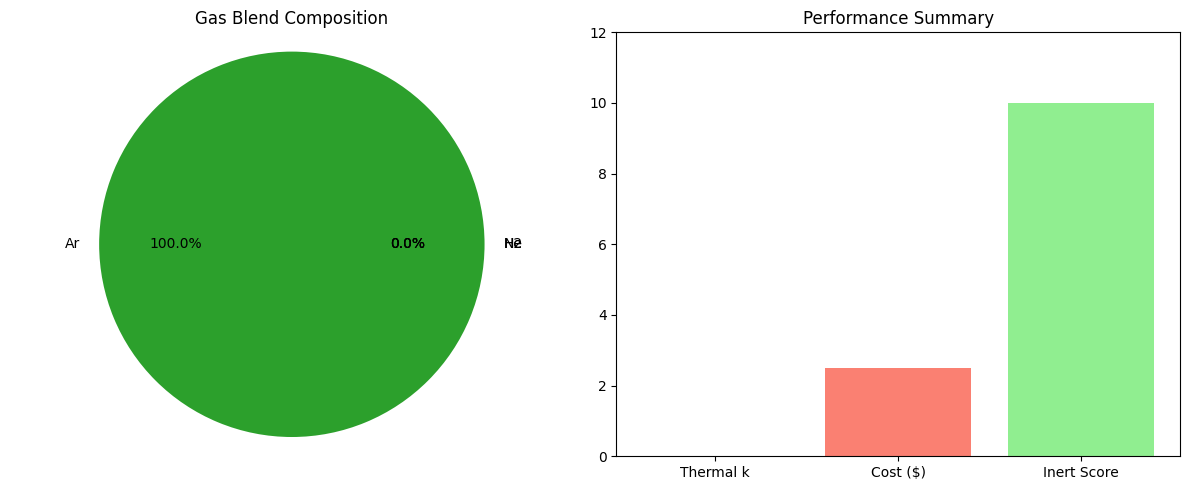

In [3]:

def run_interface():
    tp_slider = widgets.FloatSlider(value=0.13, min=0.01, max=0.18, step=0.005, description='Target k (W/m·K)')
    lc_slider = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Cost Weight')
    li_slider = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1, description='Inertness Weight')

    ui = widgets.VBox([tp_slider, lc_slider, li_slider])

    def update(_):
        mix = optimize_mix(tp_slider.value, lc_slider.value, li_slider.value)
        df = pd.DataFrame({
            "Gas": gas_names,
            "Proportion (%)": np.round(mix * 100, 2),
            "Thermal Cond. (W/m·K)": thermal_cond,
            "Cost ($/m³)": cost,
            "Inert Score": inert_score
        })
        display(df)
        print(f"\n👉 Effective Thermal Conductivity: {np.dot(mix, thermal_cond):.4f} W/m·K")
        print(f"👉 Blend Cost: ${np.dot(mix, cost):.2f} / m³")
        print(f"👉 Inertness Score: {np.dot(mix, inert_score):.2f} / 10")
        show_charts(mix)

    for slider in [tp_slider, lc_slider, li_slider]:
        slider.observe(update, names='value')

    display(ui)
    update(None)

run_interface()
